In [63]:
# %% Import modules
import torch
torch.set_grad_enabled(False)
device = torch.device('cpu') #'cuda' if torch.cuda.is_available() else 

import plotly.express as px
import pandas as pd
import numpy as np
import einops
import importlib
import sys
from torch import Tensor
from jaxtyping import Float, Int, Bool
from typing import Callable, Optional

from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.utils import get_act_name
import plotly.graph_objects as go

import seaborn as sns
from matplotlib import pyplot as plt
sns.set() # Setting seaborn as default style even if use only matplotlib

from plotting import (
    single_head_full_resid_projection,
    ntensor_to_long,
    line_with_river
)
from load_data import get_prompts_t
from utils import (
    projection,
    cos_similarity,
    reinforcement_ratio
)



In [2]:
#%% Setup model & load data
model = HookedTransformer.from_pretrained('gelu-4l')
model.cfg.use_attn_result = True
model.to(device)

prompts_t = get_prompts_t()

Loaded pretrained model gelu-4l into HookedTransformer
Moving model to device:  cpu
Loading 80 prompts from c4-tokenized-2b...


  0%|          | 0/80 [00:00<?, ?it/s]

Loading 20 prompts from code-tokenized...


  0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
# %% Projection of 8 heads in layer 2 to 0.2 output, mean across 50 prompts, 1024 sequence positions each
BATCH_SIZE = 100
TRUNCATE_SIZE = 128

# Cache activations for writer and sender heads
writer_hook_name = get_act_name("result", 0)
cleaner_hook_name = get_act_name("result", 2)

proj_func = reinforcement_ratio
_, cache = model.run_with_cache(
    prompts_t[:BATCH_SIZE],
    names_filter= lambda name: name in [writer_hook_name, cleaner_hook_name]
)

# Calc projections
writer_direction = cache[writer_hook_name]
cleaner_directions = cache[cleaner_hook_name]

projections = torch.zeros((model.cfg.n_heads, BATCH_SIZE, model.cfg.n_ctx))
for i in range(model.cfg.n_heads):
    projections[i, :, :] = proj_func(writer_direction[:, :, 2, :], cleaner_directions[:, :, i, :])

In [11]:
# Calc mean, stddev for each bin
n_bins = 1024
proj_bins = einops.rearrange(projections, "nheads batch (nbins binsize) -> nheads batch nbins binsize", nbins=n_bins)
proj_mean_over_prompts = einops.reduce(proj_bins, "nheads batch nbins binsize -> nheads nbins binsize", "mean")

# Mean per bin
proj_means = einops.reduce(proj_mean_over_prompts, "nheads nbins binsize -> nheads nbins", "mean")

# Error per bin: 2* stddev
proj_err = 2 * einops.reduce(proj_mean_over_prompts, "nheads nbins binsize -> nheads nbins", torch.std)

In [12]:
# Plot
df = ntensor_to_long(proj_means)
df.columns = ["values", "heads", "bins"]
df['err'] = proj_err.flatten()
line_with_river(
    data_frame=df,
    x="bins",
    y="values",
    color="heads",
    error_y="err",
    error_y_mode="band",
    labels={
        "bins": f"sequence positions of bin size {model.cfg.n_ctx//n_bins}",
        "values": "projection value"
    },
    title=f"Projection of layer 2 heads to H0.2 output direction<br>Average across {BATCH_SIZE} prompts, 1024 sequence positions using {proj_func.__name__}",
    width=800,
)

In [13]:
projections.shape # [batch, pos] -> [pos, (stats: mean, quantiles)]
# PV


torch.Size([8, 100, 1024])

In [69]:
layer, head = 0, 2


def get_attn_result_norm_by_pos_df(
    cache: ActivationCache,
    writer_layer: int = 0,
    writer_head: int = 2,
) -> Float[Tensor, "batch pos"]:

    attn_out_H02: Float[Tensor, "batch pos dmodel"] = cache["result", writer_layer][
        :, :, writer_head, :
    ]
    attn_out_H02_norm: Float[Tensor, "batch pos"] = attn_out_H02.norm(dim=-1)

    attn_out_mean = attn_out_H02_norm.mean(dim=0)
    attn_out_q1 = attn_out_H02_norm.quantile(0.01, dim=0)
    attn_out_q25 = attn_out_H02_norm.quantile(0.25, dim=0)
    attn_out_q50 = attn_out_H02_norm.quantile(0.50, dim=0)
    attn_out_q75 = attn_out_H02_norm.quantile(0.75, dim=0)
    attn_out_q99 = attn_out_H02_norm.quantile(0.99, dim=0)

    df = pd.DataFrame(
        {
            "mean": attn_out_mean,
            "q1": attn_out_q1,
            "q25": attn_out_q25,
            "q50": attn_out_q50,
            "q75": attn_out_q75,
            "q99": attn_out_q99,
        }
    )

    return df


def get_projection_df(
    cache: ActivationCache,
    model: HookedTransformer,
    batch_size: int,
    from_layer: int = 2,
    from_head: Optional[int] = None,
    to_layer: int = 0,
    to_head: int = 2,
    proj_func: Callable = reinforcement_ratio,
):

    # Cache activations for writer and sender heads
    writer_hook_name = get_act_name("result", to_layer)
    cleaner_hook_name = get_act_name("result", from_layer)

    # Calc projections
    writer_direction = cache[writer_hook_name]
    cleaner_directions = cache[cleaner_hook_name]

    projections = torch.zeros((model.cfg.n_heads, batch_size, model.cfg.n_ctx))
    for i in range(model.cfg.n_heads):
        projections[i, :, :] = proj_func(
            writer_direction[:, :, to_head, :], cleaner_directions[:, :, i, :]
        )

    if from_head is not None: # select one head
        projections = projections[from_head, :, :]
    else: # sum up 8 heads
        projections = projections.sum(dim=0)

    projection_mean = projections.mean(dim=-2)
    projection_q1 = projections.quantile(0.01, dim=-2)
    projection_q25 = projections.quantile(0.25, dim=-2)
    projection_q50 = projections.quantile(0.50, dim=-2)
    projection_q75 = projections.quantile(0.75, dim=-2)
    projection_q99 = projections.quantile(0.99, dim=-2)

    df = pd.DataFrame(
        {
            "mean": projection_mean,
            "q1": projection_q1,
            "q25": projection_q25,
            "q50": projection_q50,
            "q75": projection_q75,
            "q99": projection_q99,
        }
    )

    return df

def fill_subplot(df, axes, axes_idx, title, ylabel=None):
    axes[axes_idx].plot(df["mean"], color="black")

    sns.lineplot(ax=axes[axes_idx], data=df, x=df.index, y='mean', color="black")
    axes[axes_idx].fill_between(df.index, df['q1'], df['q99'], alpha=0.2, color='blue', edgecolor=None)
    axes[axes_idx].fill_between(df.index, df['q25'], df['q75'], alpha=0.3, color='blue', edgecolor=None)

    axes[axes_idx].set_title(title)
    axes[axes_idx].set_xlim(0, 1024)
    
    if ylabel is not None:
        axes[axes_idx].set_ylabel(ylabel)
    if axes_idx == 2:
        axes[axes_idx].set_xlabel("sequence position")

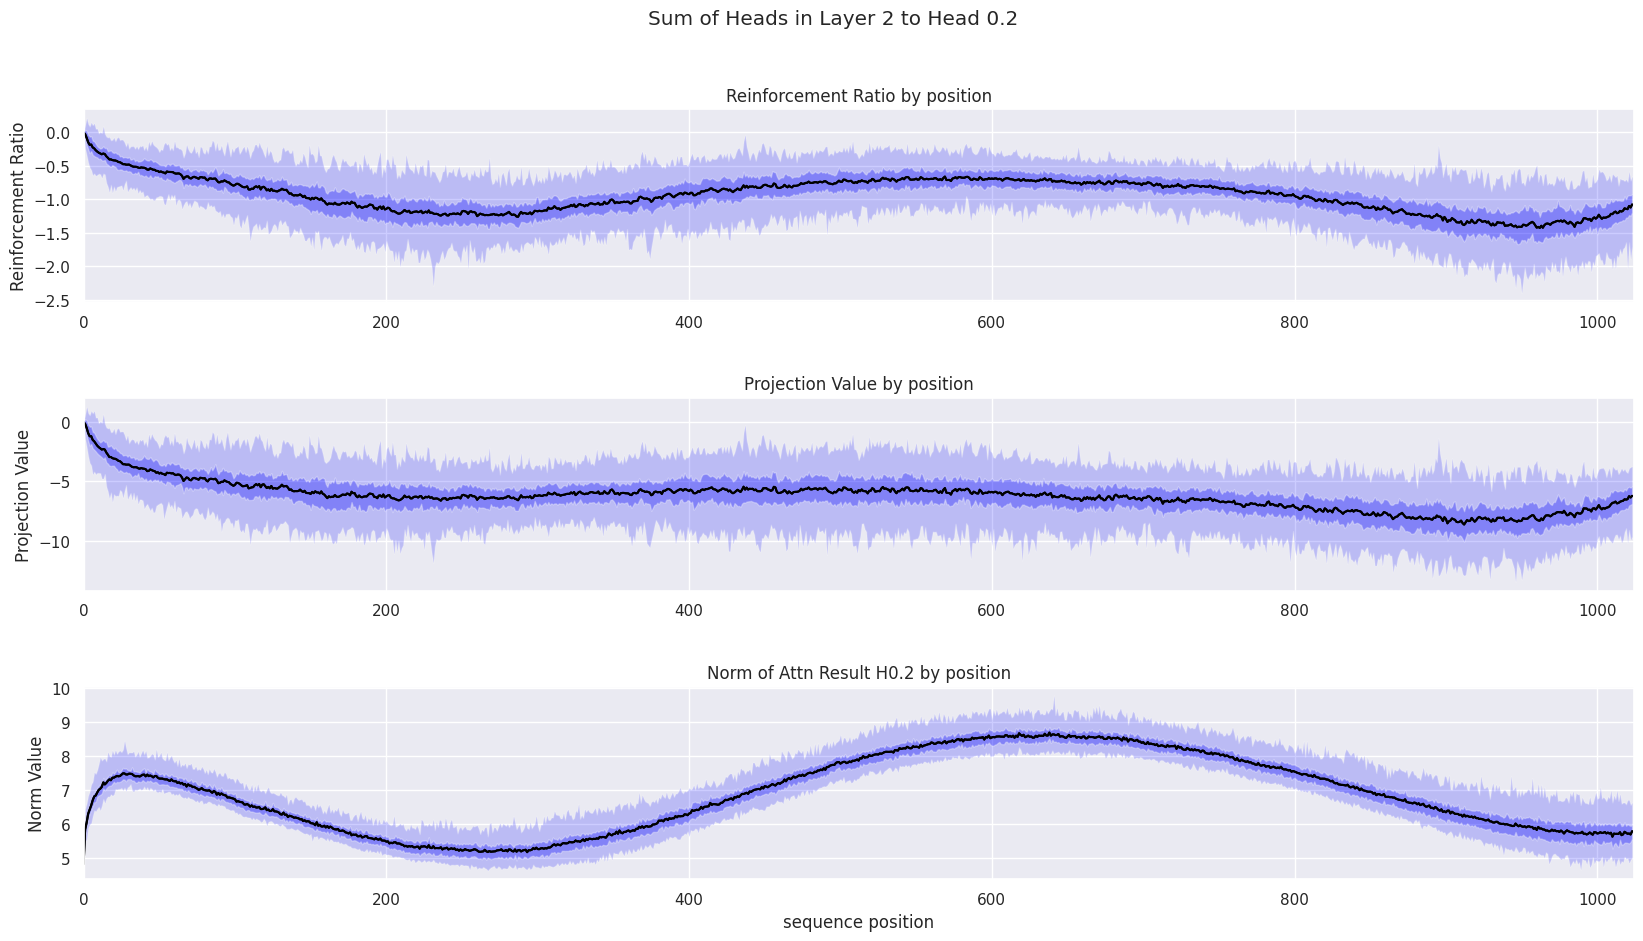

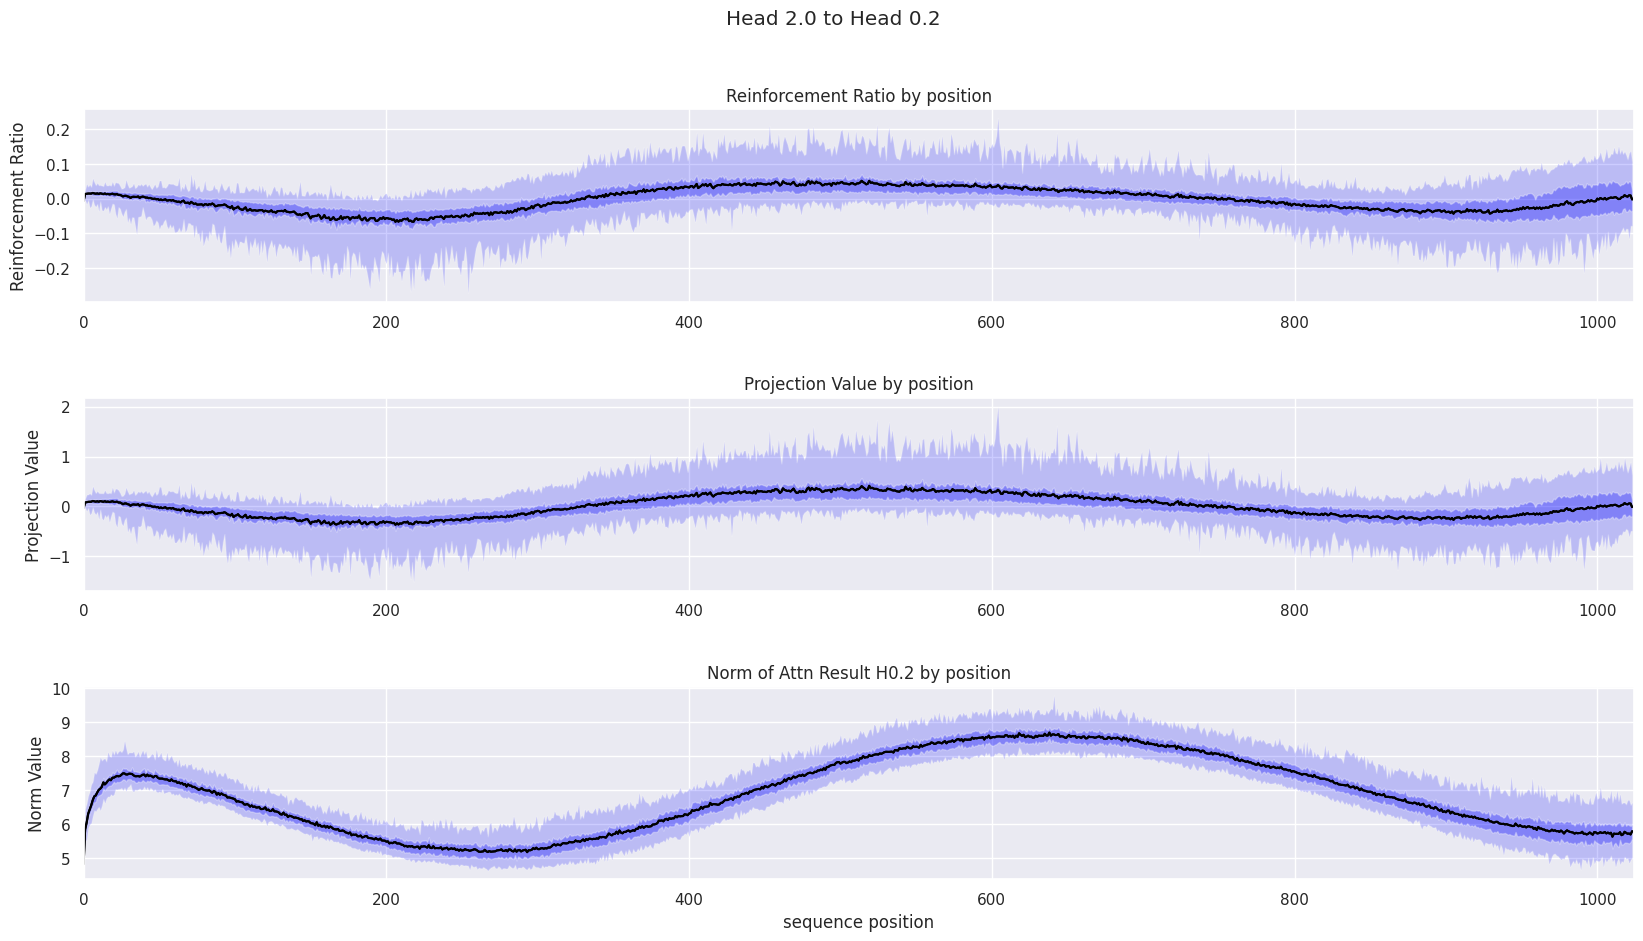

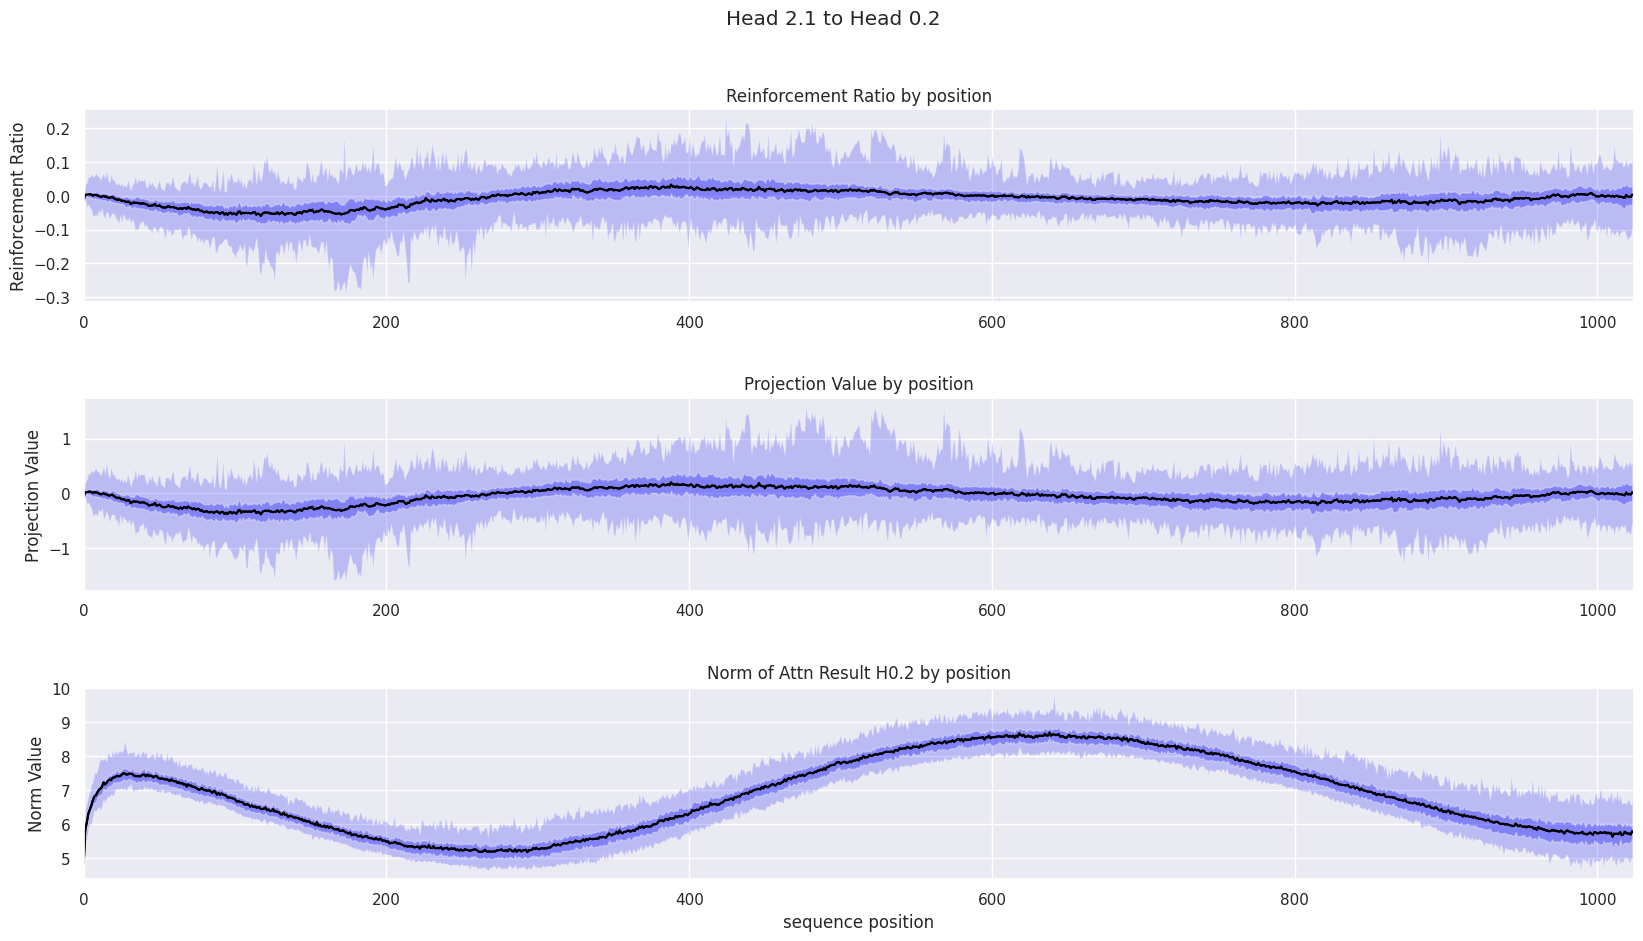

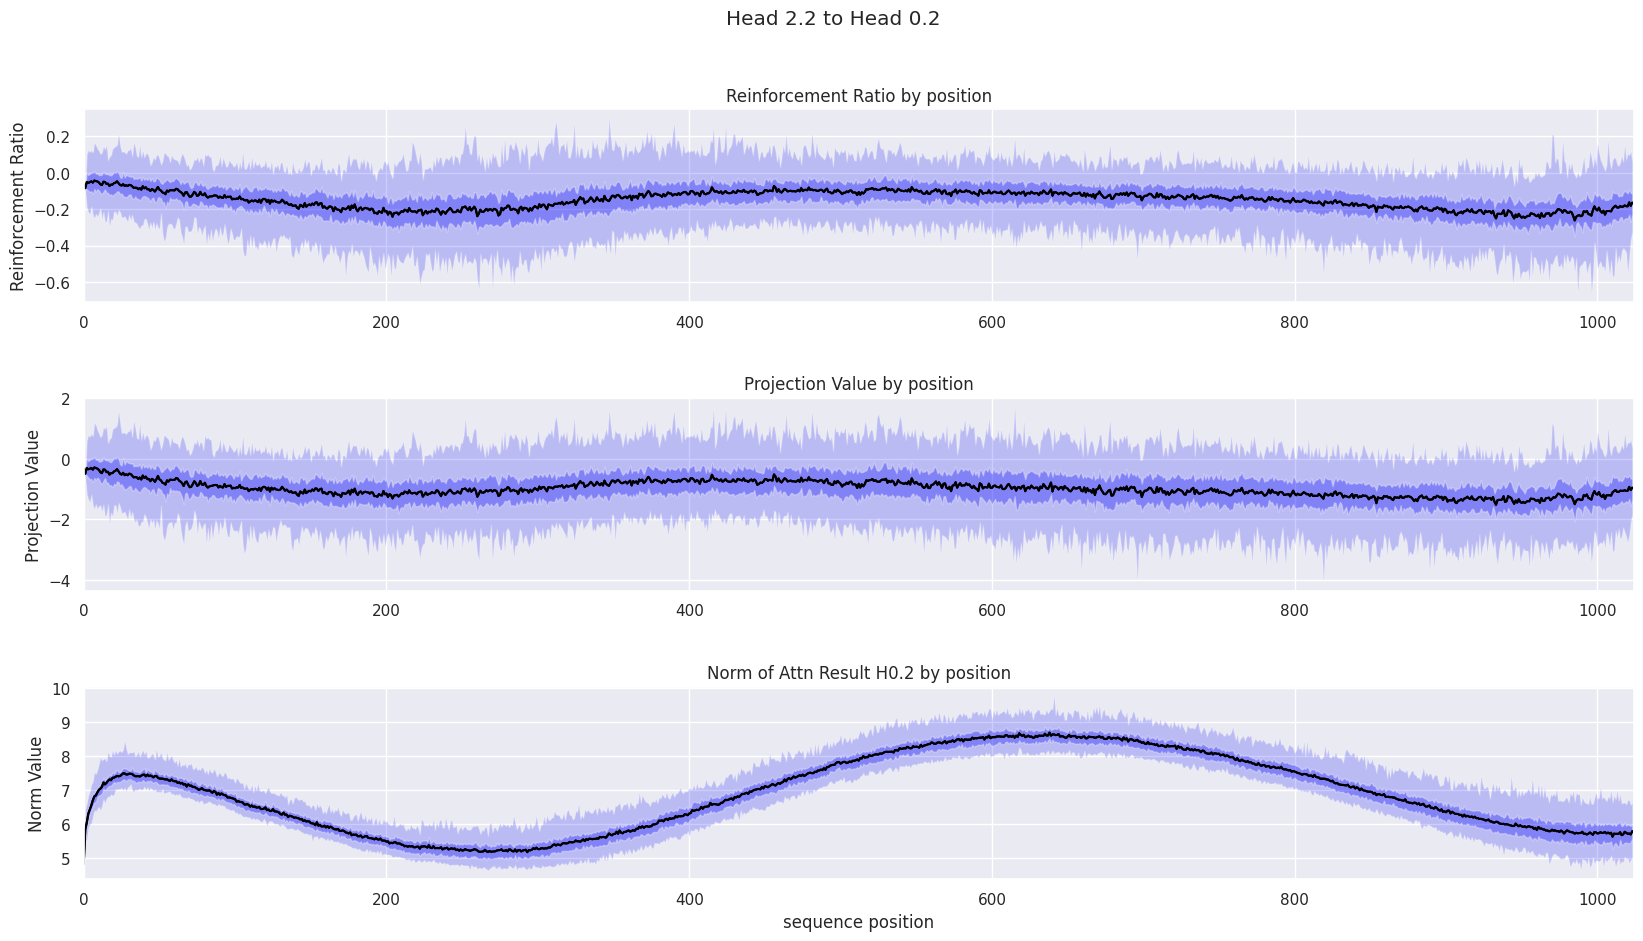

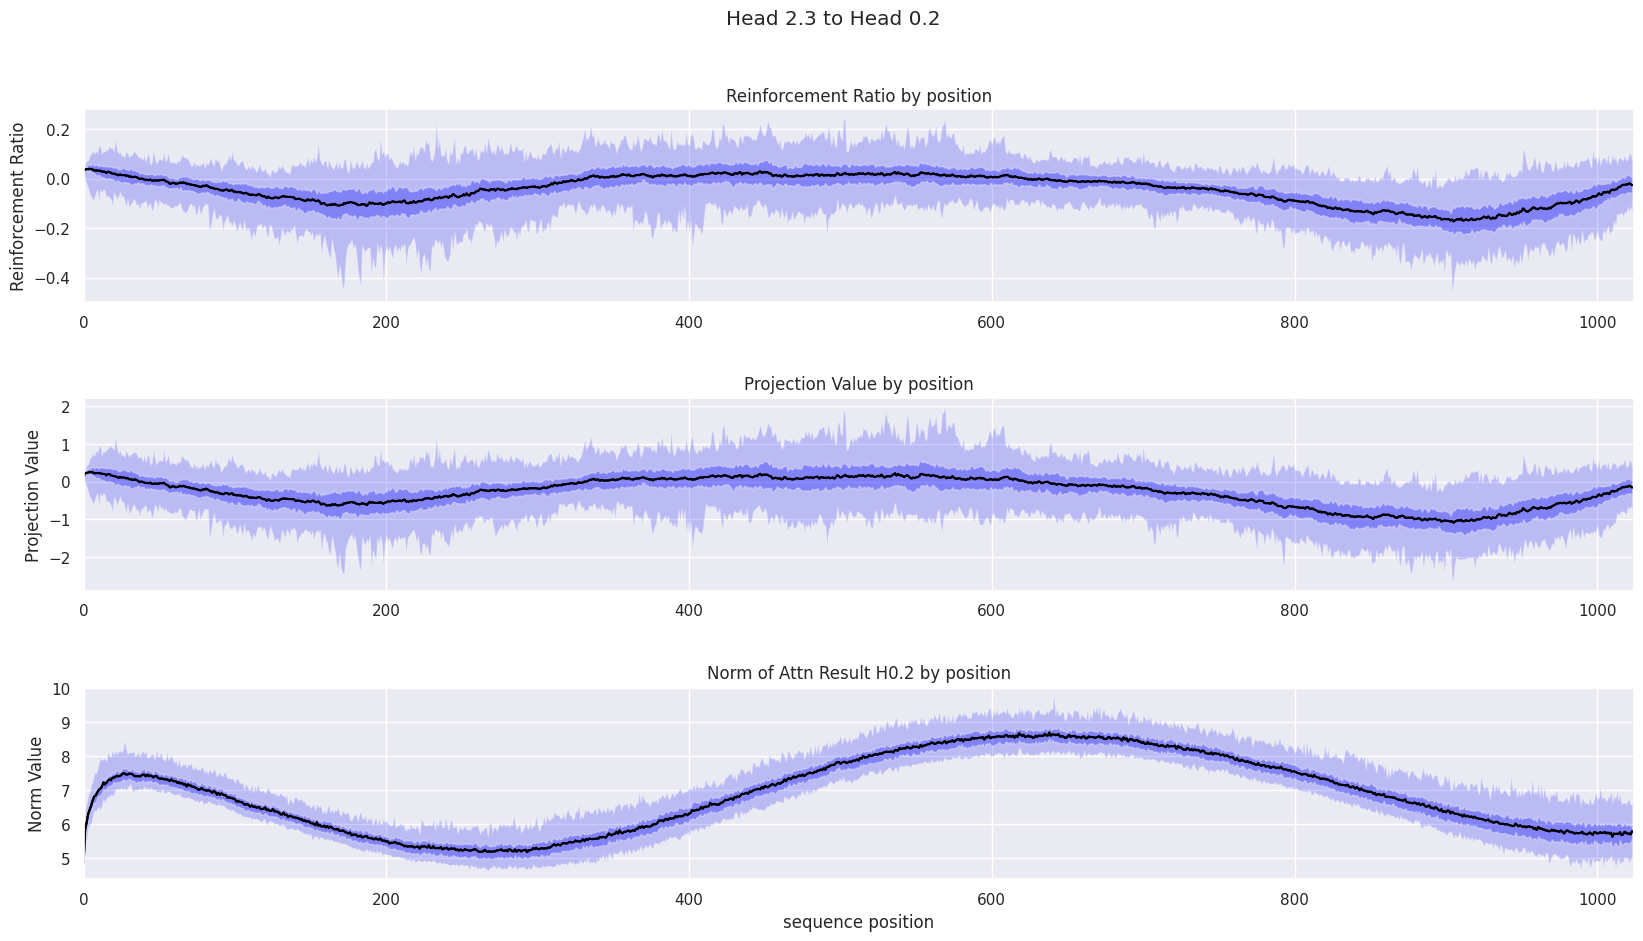

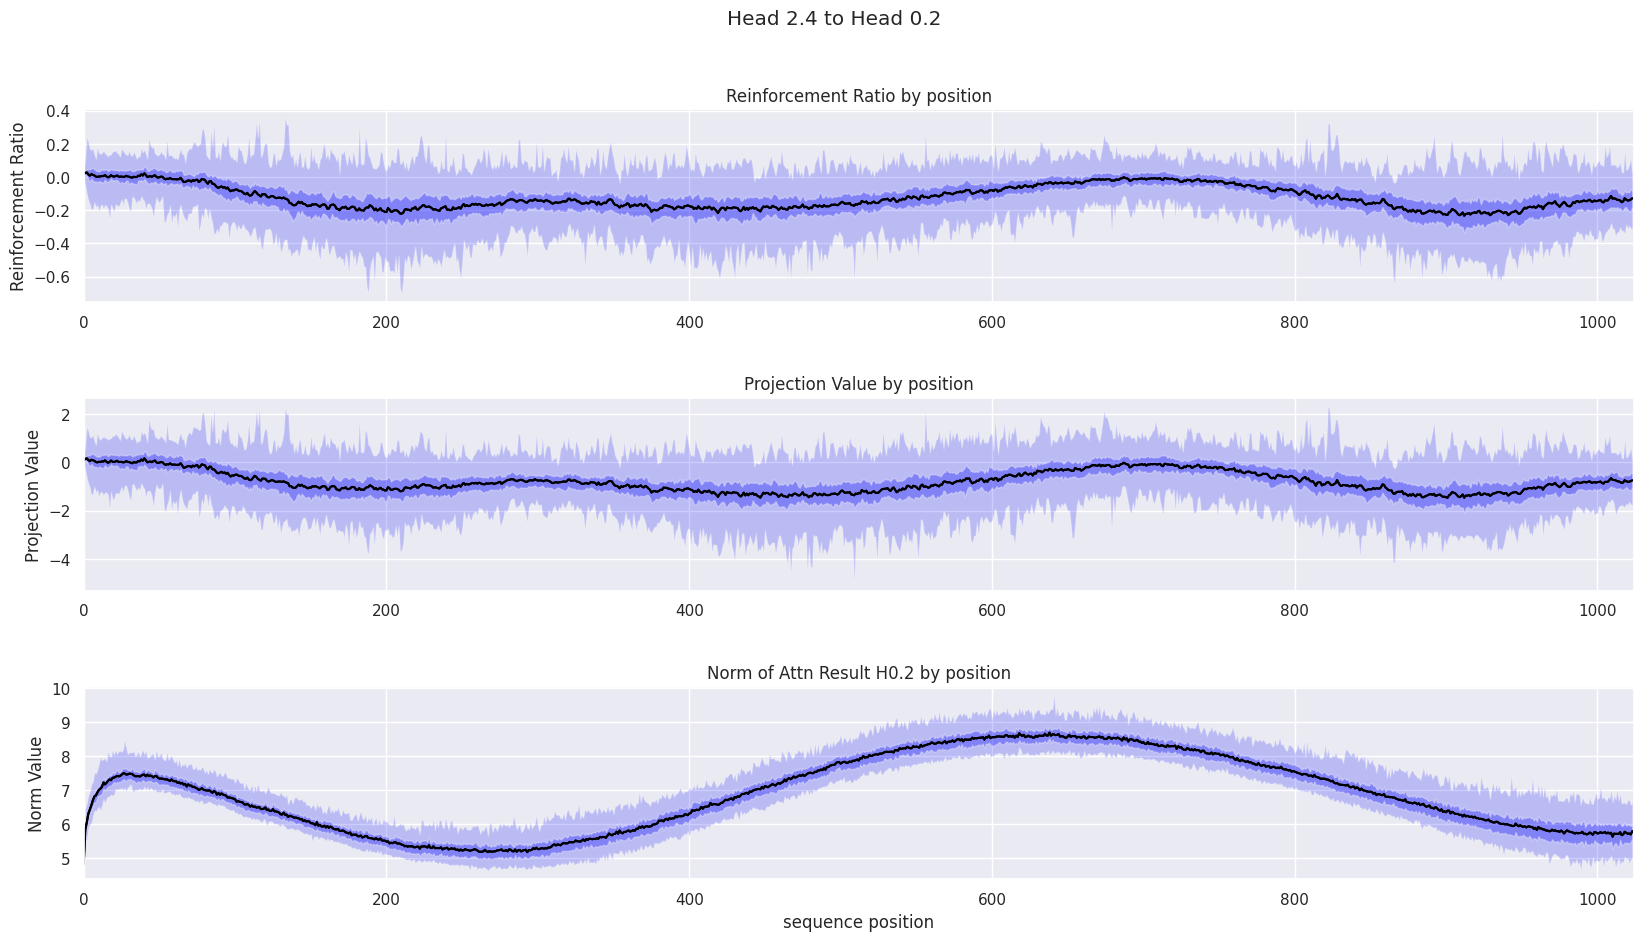

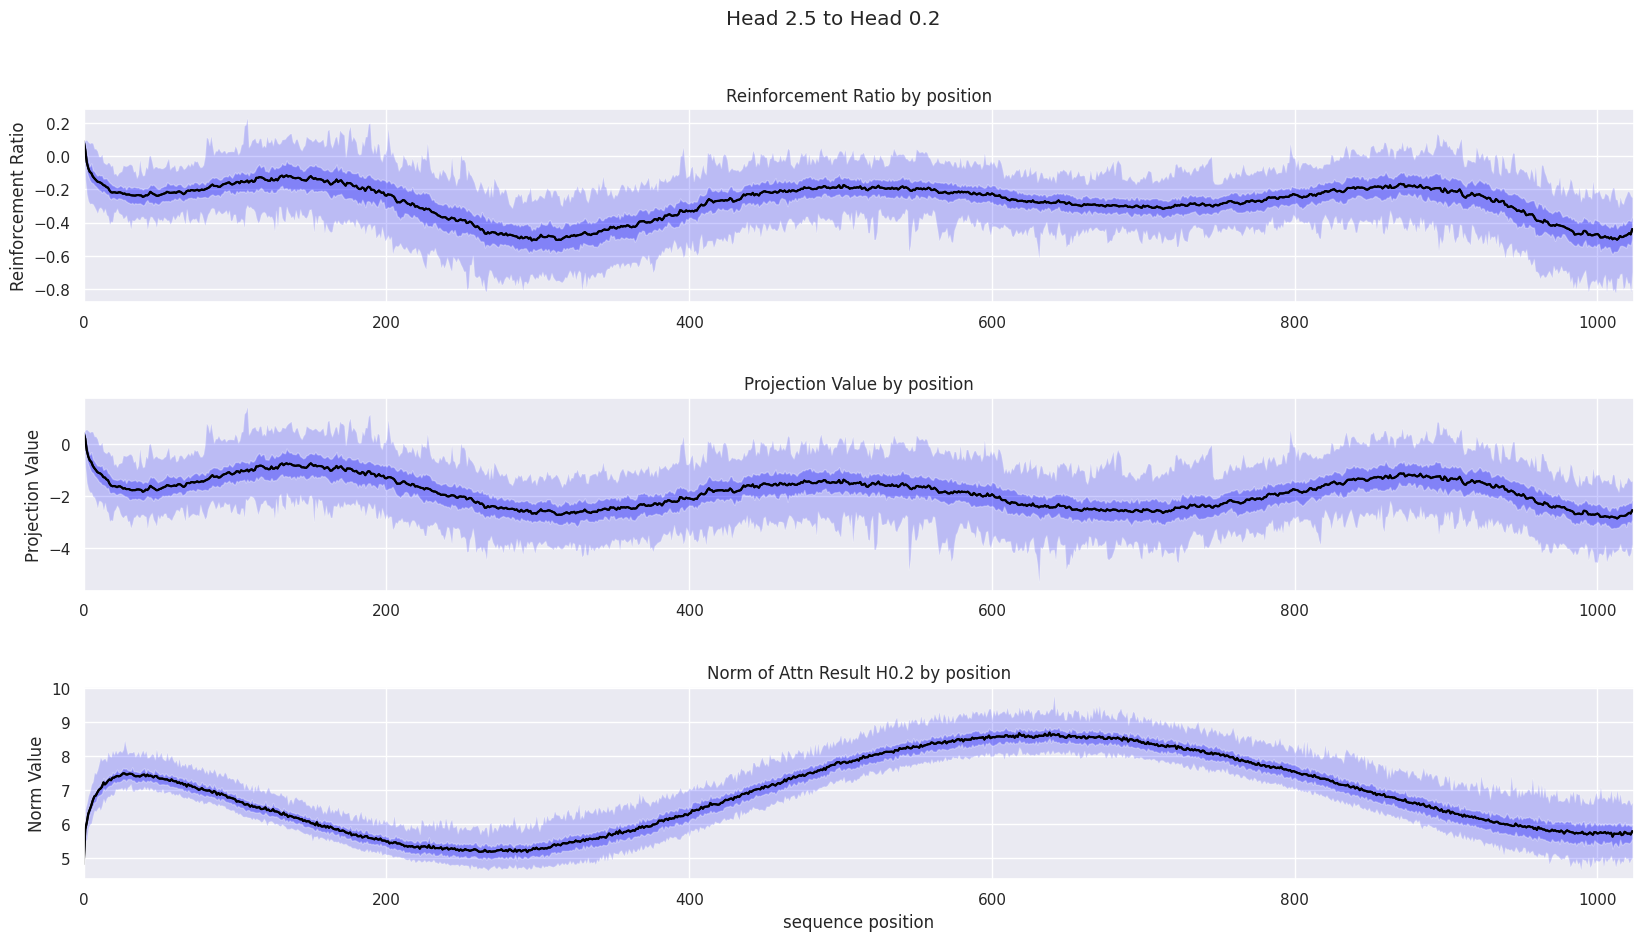

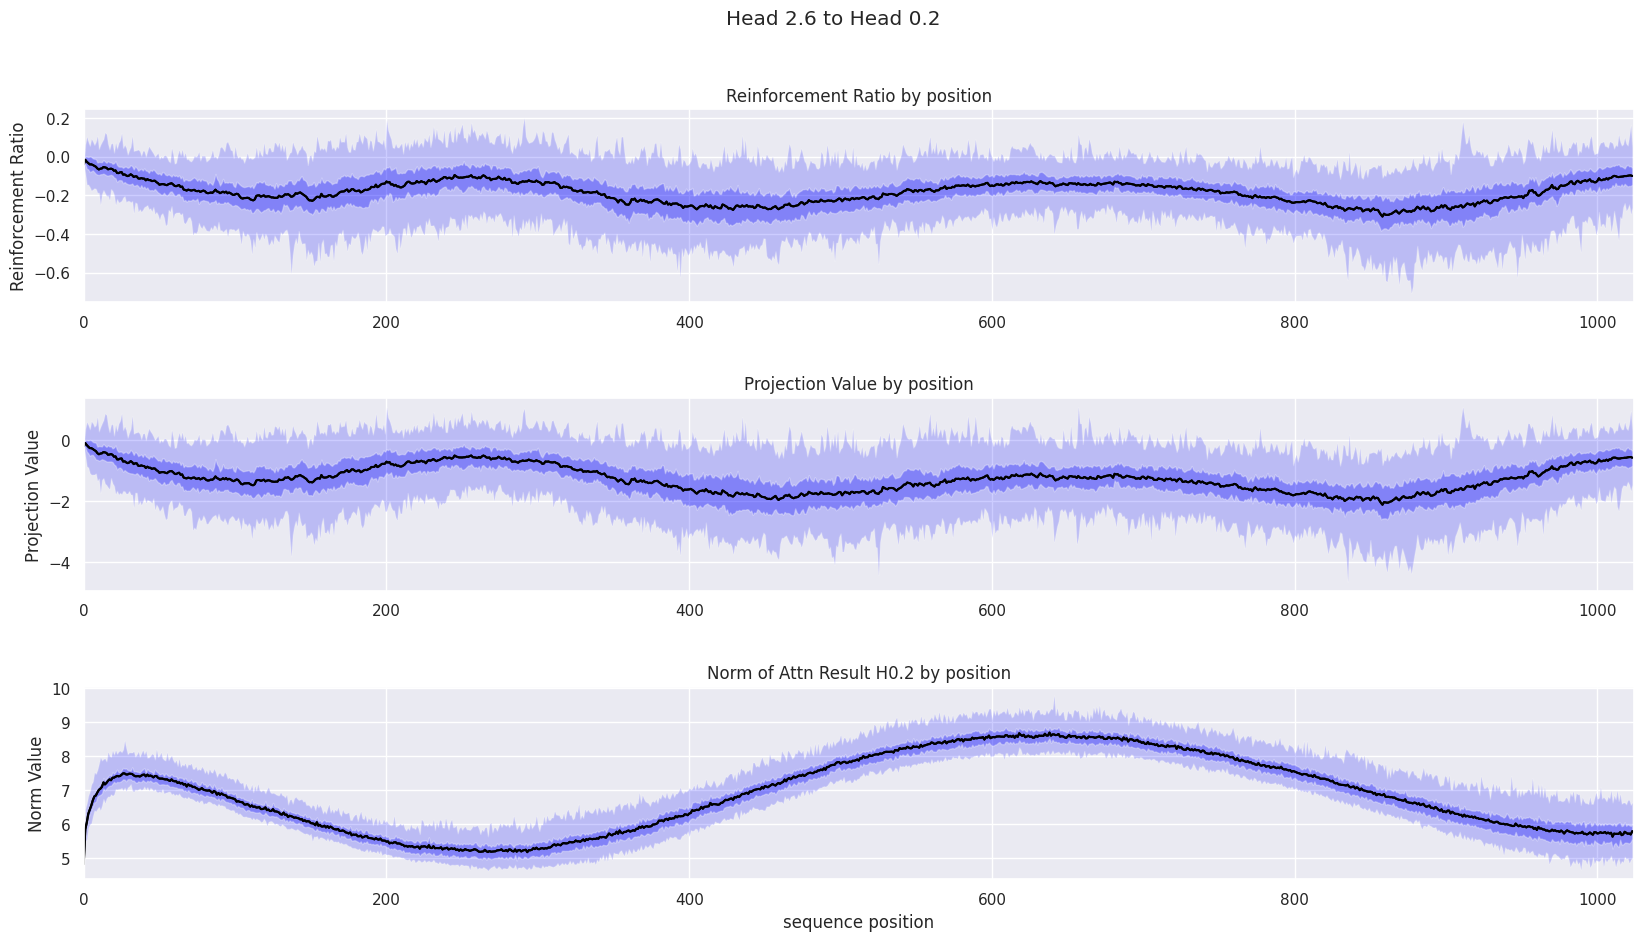

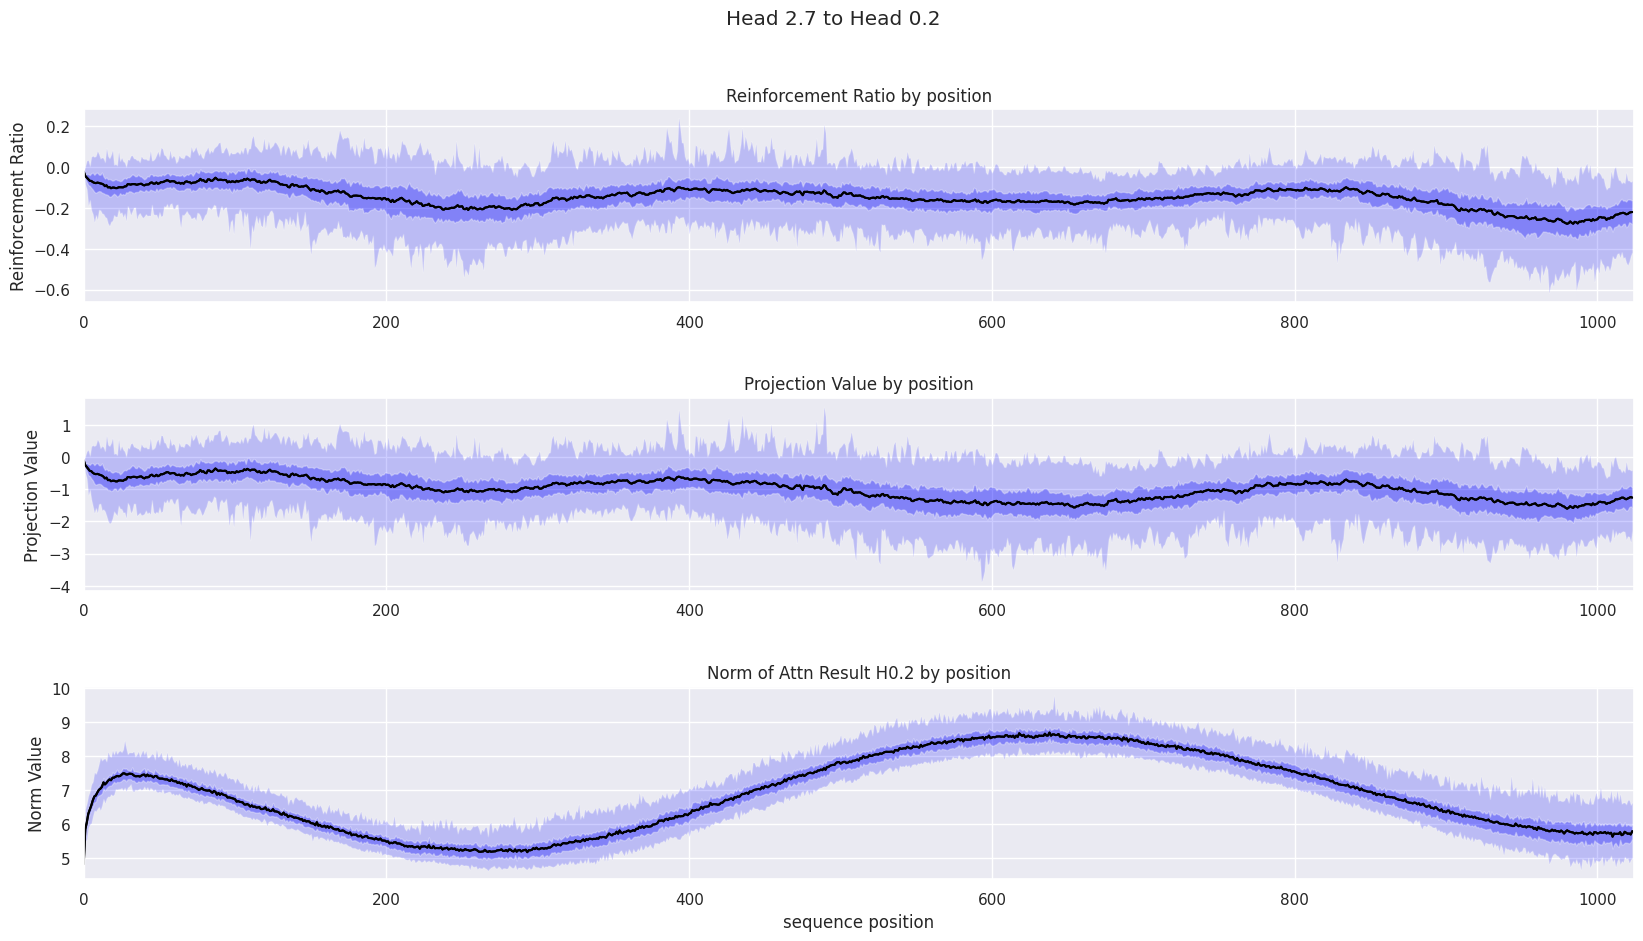

In [78]:

writer_layer, writer_head = 0, 2
cleaner_layer = 2

for cleaner_head in [None, *range(8)]:
    RR_df = get_projection_df(cache, model, BATCH_SIZE, proj_func=reinforcement_ratio, from_head=cleaner_head)
    PV_df = get_projection_df(cache, model, BATCH_SIZE, proj_func=projection, from_head=cleaner_head)
    H02_norm_df = get_attn_result_norm_by_pos_df(cache)

    fig, axes = plt.subplots(3, 1, figsize=(20, 10))

    if cleaner_head is None:
        fig.suptitle(f'Sum of Heads in Layer {cleaner_layer} to Head {writer_layer}.{writer_head}')
    else:
        fig.suptitle(f'Head {cleaner_layer}.{cleaner_head} to Head {writer_layer}.{writer_head}')

    fill_subplot(RR_df, axes, 0, "Reinforcement Ratio by position", "Reinforcement Ratio")
    fill_subplot(PV_df, axes, 1, "Projection Value by position", "Projection Value")
    fill_subplot(H02_norm_df, axes, 2, "Norm of Attn Result H0.2 by position", "Norm Value")

    plt.subplots_adjust(hspace=0.5)
    plt.savefig(f"plots/H{cleaner_layer}-{cleaner_head}_to_H{writer_layer}-{writer_head}.png")
    plt.show()


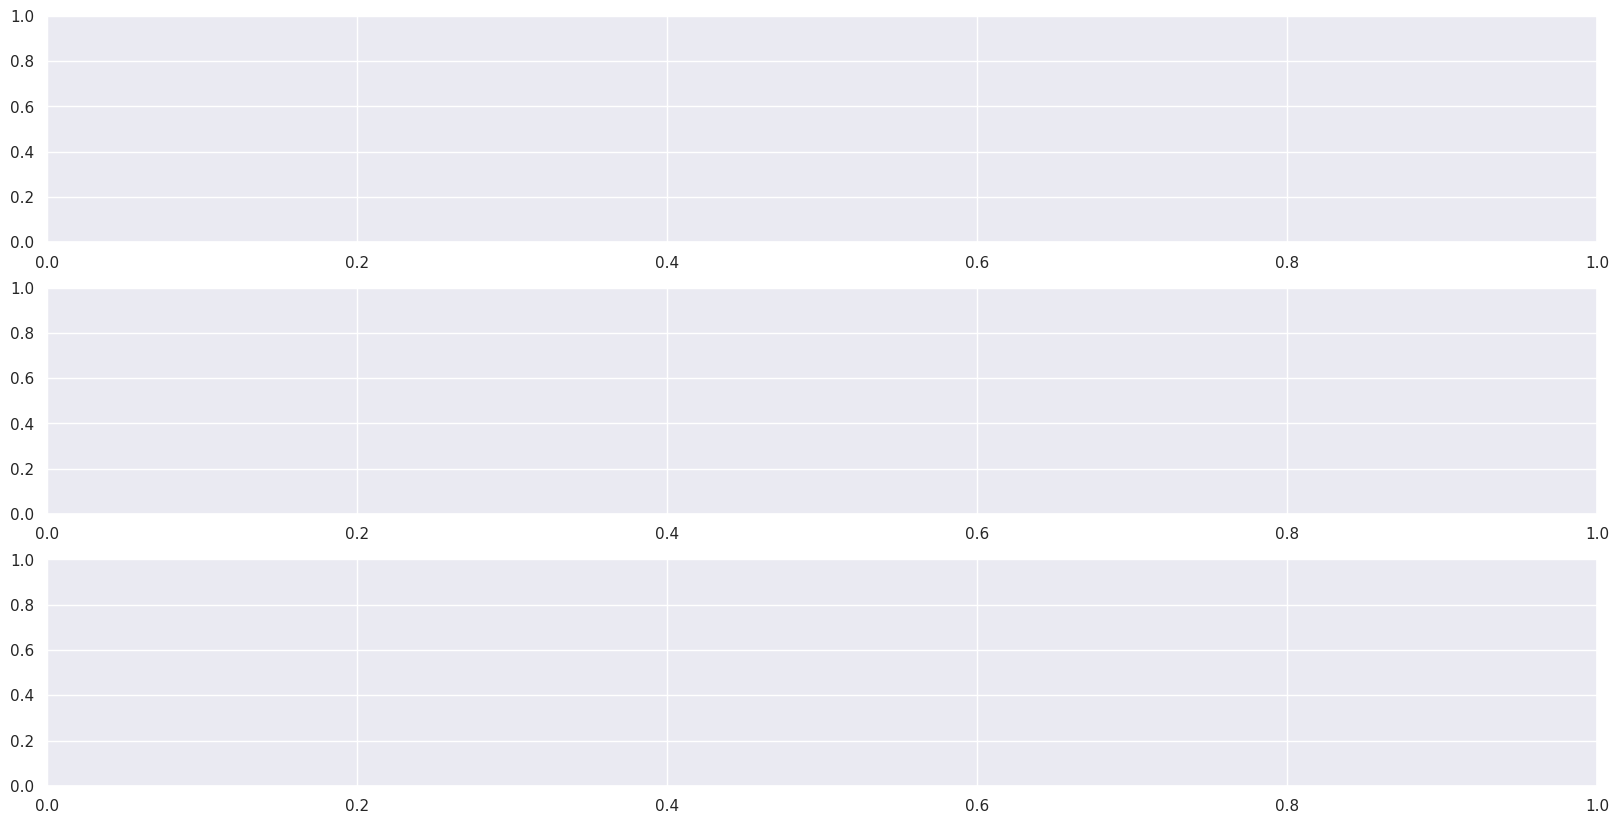

In [86]:

writer_layer, writer_head = 0, 2
cleaner_layer = 2

# try to put all lines in one plot
fig, axes = plt.subplots(3, 1, figsize=(20, 10))

RR_dfs, PV_dfs = pd.DataFrame(), pd.DataFrame()
H02_norm_df = get_attn_result_norm_by_pos_df(cache)

for cleaner_head in range(8):
    tmp_RR_df = get_projection_df(cache, model, BATCH_SIZE, proj_func=reinforcement_ratio, from_head=cleaner_head)
    tmp_PV_df = get_projection_df(cache, model, BATCH_SIZE, proj_func=projection, from_head=cleaner_head)
    tmp_RR_df["head_name"] = f"H0.{cleaner_head}"
    tmp_PV_df["head_name"] = f"H0.{cleaner_head}"

    RR_dfs = pd.concat([RR_dfs, tmp_RR_df], axis=0)
    PV_dfs = pd.concat([PV_dfs, tmp_PV_df], axis=0)

# RR_df_concat = 
    # if cleaner_head is None:
    #     fig.suptitle(f'Sum of Heads in Layer {cleaner_layer} to Head {writer_layer}.{writer_head}')
    # else:
    #     fig.suptitle(f'Head {cleaner_layer}.{cleaner_head} to Head {writer_layer}.{writer_head}')

    # fill_subplot(RR_df, axes, 0, "Reinforcement Ratio by position", "Reinforcement Ratio")
    # fill_subplot(PV_df, axes, 1, "Projection Value by position", "Projection Value")
    # fill_subplot(H02_norm_df, axes, 2, "Norm of Attn Result H0.2 by position", "Norm Value")

    # plt.subplots_adjust(hspace=0.5)
    # plt.show()


In [87]:
RR_dfs


mean        q1       q25       q50       q75       q99 head_name
0    -0.007003 -0.007003 -0.007003 -0.007003 -0.007003 -0.007003      H0.0
1     0.013341 -0.004138  0.011462  0.012922  0.015386  0.026002      H0.0
2     0.014170 -0.015577  0.010028  0.015175  0.018225  0.042397      H0.0
3     0.014693 -0.004194  0.011412  0.015119  0.018621  0.034852      H0.0
4     0.014694 -0.025508  0.011515  0.015933  0.021332  0.040891      H0.0
...        ...       ...       ...       ...       ...       ...       ...
1019 -0.230304 -0.466439 -0.294222 -0.221747 -0.167732 -0.025921      H0.7
1020 -0.228983 -0.479623 -0.287658 -0.219647 -0.157721 -0.063731      H0.7
1021 -0.222951 -0.462078 -0.269403 -0.217133 -0.158043 -0.065201      H0.7
1022 -0.220173 -0.433795 -0.272977 -0.202939 -0.158922 -0.071634      H0.7
1023 -0.219598 -0.415008 -0.278775 -0.206540 -0.164724 -0.066718      H0.7

[8192 rows x 7 columns]

<Axes: ylabel='mean'>

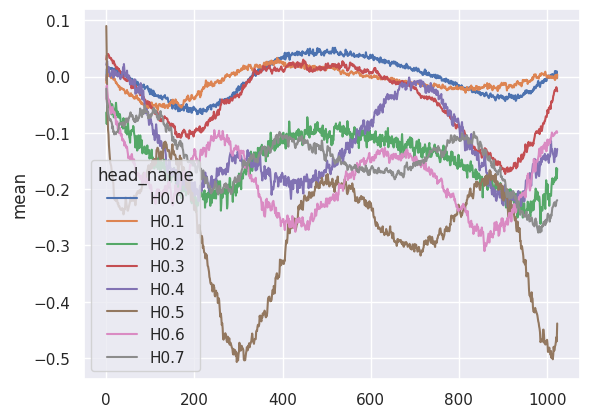

In [88]:
sns.lineplot(
    data=RR_dfs,
    x=RR_dfs.index,
    y="mean",
    hue="head_name",
)